In [9]:
pip install plaid-python


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import json
import re
from datetime import datetime, timedelta

# Bibliothèques pour l'environnement
from dotenv import load_dotenv, dotenv_values

# Bibliothèques d'analyse de données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèques Plaid
import plaid
from plaid.api import plaid_api
from plaid.model.plaid_error import PlaidError
from plaid.model.products import Products
from plaid.model.link_token_create_request import LinkTokenCreateRequest
from plaid.model.country_code import CountryCode
from plaid.model.link_token_get_request import LinkTokenGetRequest
from plaid.model.accounts_get_request import AccountsGetRequest
from plaid.model.transactions_get_request import TransactionsGetRequest
from plaid.configuration import Configuration
from plaid.api_client import ApiClient
from plaid.model.item_public_token_exchange_request import ItemPublicTokenExchangeRequest
from plaid.model.sandbox_public_token_create_request import SandboxPublicTokenCreateRequest

In [2]:
load_dotenv() 
env = 'sand'
PLAID_CLIENT_ID = os.getenv("PLAID_CLIENT_ID")
PLAID_SECRET = os.getenv("PLAID_SECRET_" + env)
PLAID_ENV = os.getenv("PLAID_ENV_" + env)
institutionId = "ins_1"

### Fonctions

In [3]:
def get_plaid_client():
    """
    Configure et retourne un client Plaid
    """
    configuration = Configuration(
        host=PLAID_ENV,
        api_key={
            'clientId': PLAID_CLIENT_ID,
            'secret': PLAID_SECRET,
        }
    )
    api_client = plaid.ApiClient(configuration)
    return plaid_api.PlaidApi(api_client)

def format_transaction(transaction):
    """
    Formate une transaction Plaid pour le frontend
    """
    return {
        "id": transaction.transaction_id,
        "date": transaction.date,
        "name": transaction.name,
        "amount": transaction.amount,
        "category": ', '.join(transaction.category) if transaction.category else "Non catégorisé",
        "payment_channel": transaction.payment_channel,
        "pending": transaction.pending,
        "merchant_name": transaction.merchant_name
    }

def create_sandbox_token(institution_id="ins_1"):
    """
    Crée un token public sandbox pour les tests
    """
    client = get_plaid_client()
    
    request = SandboxPublicTokenCreateRequest(
        institution_id=institution_id,
        initial_products=[Products('transactions')]
    )
    response = client.sandbox_public_token_create(request)
    return response.public_token

def exchange_public_token(public_token):
    """
    Échange un token public contre un token d'accès permanent
    """
    client = get_plaid_client()
    
    exchange_request = ItemPublicTokenExchangeRequest(
        public_token=public_token
    )
    exchange_response = client.item_public_token_exchange(exchange_request)
    
    # Dans une application réelle, stockez cet access_token en sécurité
    access_token = exchange_response.access_token
    item_id = exchange_response.item_id
    
    return {
        "access_token": access_token,
        "item_id": item_id
    }

def get_user_transactions(access_token, days=30):
    """
    Récupère les transactions des X derniers jours
    """
    client = get_plaid_client()
    
    # Calculer les dates de début et de fin
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days)
    
    # Récupérer les transactions
    request = TransactionsGetRequest(
        access_token=access_token,
        start_date=start_date,
        end_date=end_date
    )
    
    response = client.transactions_get(request)
    transactions = response['transactions']
    
    # Formater les transactions pour le frontend
    return [format_transaction(transaction) for transaction in transactions]

### Recuperation des transactions

In [4]:
# 1. Créer un token public sandbox
print("Création d'un token sandbox...")
public_token = create_sandbox_token(institutionId)
print(f"Token public créé: {public_token}")

Création d'un token sandbox...
Token public créé: public-sandbox-137f81f3-44c4-4350-a29c-5d8a0c88b88b


In [5]:
# 2. Échanger le token public contre un token d'accès
print("\nÉchange du token public contre un token d'accès...")
token_data = exchange_public_token(public_token)
access_token = token_data["access_token"]
item_id = token_data["item_id"]
print(f"Token d'accès obtenu: {access_token}")
print(f"Item ID: {item_id}")


Échange du token public contre un token d'accès...
Token d'accès obtenu: access-sandbox-4842d69a-39a0-4655-a059-17ce3b75ae22
Item ID: E5nbEEVEK3FA3BWQo6dPCleQj8EN56cXddjzb


In [6]:
# 3. Récupérer les transactions avec le token d'accès
print("\nRécupération des transactions...")
transactions = get_user_transactions(access_token, days=90)
print(f"Nombre de transactions récupérées: {len(transactions)}")


Récupération des transactions...
Nombre de transactions récupérées: 17


In [7]:
df_transactions = pd.DataFrame(transactions)
df_transactions.head(10)

,id,date,name,amount,category,payment_channel,pending,merchant_name
0,kqpPjjMjDAIx3Vzwka5Kc3JeBAx39btL1ALjP,2025-05-02,Uber 072515 SF**POOL**,6.33,Non catégorisé,other,False,None
1,a5PKyy6yX7FWwx9ZEGBLck8zVJEkdbtZKVZaK,2025-04-29,Tectra Inc,500.00,Non catégorisé,other,False,None
2,P5j6XXkXW7Fax6qZdRBgCXjZa5wXvVuoyVok6,2025-04-28,AUTOMATIC PAYMENT - THANK,2078.50,"Payment, Credit Card",other,False,None
3,N5M6bb8bNPFxk9AMLdvpcXD3a5xXk6uyAkyjp,2025-04-28,KFC,500.00,"Food and Drink, Restaurants, Fast Food",other,False,None
4,4opDjjnjbZFZb1wk6vBPsX7eqW3XEnuJR4Jrp,2025-04-28,Madison Bicycle Shop,500.00,Non catégorisé,other,False,None
5,3pLowwnwbJSX75vPaVlxCkP57QKkJdtZV5Zrn,2025-04-19,CREDIT CARD 3333 PAYMENT *//,25.00,"Payment, Credit Card",other,False,None
6,lKJj55m5DATd3MoQb1LvhNxvXmpN4rupm6pwb,2025-04-19,Uber 063015 SF**POOL**,5.40,Non catégorisé,other,False,None
7,e5y3QQMQXwFJ8NwQMExWFlDmbqalrjCr3erdw,2025-04-18,ACH Electronic CreditGUSTO PAY 123456,5850.00,Non catégorisé,other,False,None
8,d5NBaaMaXZFng43d5BmrFByLXweBGafJnrJMR,2025-04-18,CD DEPOSIT .INITIAL.,1000.00,"Transfer, Deposit",other,False,None
9,jlkNXXLX57hezQKkxWjqijP9embjG3t6Rl6Mg,2025-04-17,Touchstone Climbing,78.50,Non catégorisé,other,False,None


In [44]:
def format_transaction(transaction):
    """
    Formate une transaction Plaid pour le frontend
    """
    # Vérifier si c'est déjà un dictionnaire avec le bon format de catégorie
    if isinstance(transaction, dict):
        # Si la catégorie est déjà au bon format, retourner tel quel
        if "category" in transaction and isinstance(transaction["category"], dict):
            return transaction
        
        # Si la catégorie est 'Non catégorisé', la convertir au bon format
        if "category" in transaction and transaction["category"] == "Non catégorisé":
            transaction["category"] = {
                "id": "other",
                "subcategory": {
                    "id": "unknown"
                }
            }
            return transaction
        
        # Si c'est un dict mais que la catégorie n'est pas au bon format,
        # on continue le traitement avec ce dictionnaire
        transaction_obj = transaction
    else:
        # Sinon, on suppose que c'est un objet Plaid
        transaction_obj = transaction
    
    # Préparer la structure de catégorie
    category_id = "other"
    subcategory_id = "unknown"
    
    # Traiter le champ category qui peut être une chaîne ou une liste
    if hasattr(transaction_obj, 'category') or (isinstance(transaction_obj, dict) and 'category' in transaction_obj):
        category_value = transaction_obj.category if hasattr(transaction_obj, 'category') else transaction_obj.get('category')
        
        # Si la catégorie est une chaîne
        if isinstance(category_value, str):
            # Cas spécial pour "Non catégorisé"
            if category_value == "Non catégorisé":
                # Utiliser les valeurs par défaut définies plus haut
                pass
            else:
                # Sinon, diviser la chaîne
                categories = category_value.split(', ')
                if categories:
                    category_id = categories[0].lower().replace(' ', '') if categories[0] else "other"
                    if len(categories) > 1:
                        subcategory_id = categories[1].lower().replace(' ', '')
        # Si c'est une liste, l'utiliser directement
        elif isinstance(category_value, list):
            categories = category_value
            if categories:
                category_id = categories[0].lower().replace(' ', '') if categories[0] else "other"
                if len(categories) > 1:
                    subcategory_id = categories[1].lower().replace(' ', '')
    
    # Construire le résultat final
    result = {
        "id": transaction_obj.id if hasattr(transaction_obj, 'id') else transaction_obj.get('id'),
        "date": transaction_obj.date if hasattr(transaction_obj, 'date') else transaction_obj.get('date'),
        "merchant_name": (transaction_obj.merchant_name if hasattr(transaction_obj, 'merchant_name') else transaction_obj.get('merchant_name')) or 
                        (transaction_obj.name if hasattr(transaction_obj, 'name') else transaction_obj.get('name')),
        "amount": transaction_obj.amount if hasattr(transaction_obj, 'amount') else transaction_obj.get('amount'),
        "category": {
            "id": category_id,
            "subcategory": {
                "id": subcategory_id
            }
        },
        "payment_channel": transaction_obj.payment_channel if hasattr(transaction_obj, 'payment_channel') else transaction_obj.get('payment_channel'),
        "pending": transaction_obj.pending if hasattr(transaction_obj, 'pending') else transaction_obj.get('pending', False),
        "is_test_data": False
    }
    
    return result

In [ ]:
# schema loader
def load_schema(filename):
    """Charge un fichier JSON depuis le chemin spécifié"""
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Fichier non trouvé: {filename}")
        return {}

# Charger les schémas
TRANSACTION_SCHEMA = load_schema('/Users/ninamessaoudi/Documents/Projects/Projets perso/CashSense/cash-sense-backend/schemas/transaction.json')
CATEGORIES_SCHEMA = load_schema('/Users/ninamessaoudi/Documents/Projects/Projets perso/CashSense/cash-sense-backend/schemas/categories.json')

In [45]:
test_data = load_schema("/Users/ninamessaoudi/Documents/Projects/Projets perso/CashSense/cash-sense-backend/notebooks/mock_transactions.json")

In [46]:
test_data

[{'amount': 713.77,
  'payment_channel': 'in store',
  'merchant_name': 'Apple Store',
  'date': '2025-05-01',
  'pending': False,
  'id': 'txn_94e71f5a3774',
  'category': {'id': 'shopping', 'subcategory': {'id': 'electronics'}}},
 {'amount': 44.53,
  'payment_channel': 'in store',
  'pending': False,
  'merchant_name': 'PlayStation Store',
  'date': '2025-05-01',
  'id': 'txn_909b994711b4',
  'category': {'id': 'entertainment', 'subcategory': {'id': 'games'}}},
 {'amount': 69.12,
  'payment_channel': 'online',
  'pending': False,
  'merchant_name': 'Disney+',
  'date': '2025-05-01',
  'id': 'txn_a626521de556',
  'category': {'id': 'entertainment', 'subcategory': {'id': 'sports'}}},
 {'amount': 24.96,
  'payment_channel': 'online',
  'pending': False,
  'merchant_name': 'Cultura',
  'date': '2025-05-01',
  'id': 'txn_ebf3f14a7d13',
  'category': {'id': 'shopping', 'subcategory': {'id': 'electronics'}}},
 {'amount': 78.41,
  'payment_channel': 'atm',
  'pending': False,
  'merchant_nam

In [47]:
formated_transaction_list = []  # Utilise une liste vide plutôt que dict
for transaction in test_data:
    formatted_transaction = format_transaction(test_data)
    formated_transaction_list.append(formatted_transaction)
formated_transaction_list

AttributeError: 'list' object has no attribute 'get'

In [38]:
# transaction_validator

"""
Module pour valider et formater les transactions selon un schéma commun
"""
import uuid
from datetime import datetime

def format_transaction(transaction_data):
    """
    Formate une transaction pour correspondre au schéma standard
    
    Args:
        transaction_data: Données de transaction (objet ou dictionnaire)
        
    Returns:
        dict: Transaction formatée selon le schéma standard
    """
    # Si l'entrée est déjà un dictionnaire conforme, le retourner tel quel
    if isinstance(transaction_data, dict):
        if "category" in transaction_data and isinstance(transaction_data["category"], dict):
            if "id" in transaction_data["category"] and "subcategory" in transaction_data["category"]:
                if isinstance(transaction_data["category"]["subcategory"], dict) and "id" in transaction_data["category"]["subcategory"]:
                    # Ajouter is_test_data si non présent
                    if "is_test_data" not in transaction_data:
                        transaction_data["is_test_data"] = False
                    return transaction_data
    
    # Initialiser un dictionnaire pour la transaction formatée
    formatted = {}
    
    # Convertir l'objet en dictionnaire si nécessaire
    if not isinstance(transaction_data, dict):
        # Extraire les attributs pour chaque champ du schéma
        source_dict = {}
        for field in TRANSACTION_SCHEMA.keys():
            if hasattr(transaction_data, field):
                source_dict[field] = getattr(transaction_data, field)
        
        # Cas spécial pour les objets Plaid qui peuvent avoir des noms différents
        if hasattr(transaction_data, 'transaction_id'):
            source_dict['id'] = transaction_data.transaction_id
        if hasattr(transaction_data, 'name') and not hasattr(transaction_data, 'merchant_name'):
            source_dict['merchant_name'] = transaction_data.name
    else:
        source_dict = transaction_data
    
    # Copier les champs existants
    for field in TRANSACTION_SCHEMA.keys():
        if field in source_dict:
            formatted[field] = source_dict[field]
    
    # Générer un ID s'il manque
    if "id" not in formatted:
        formatted["id"] = f"txn_{uuid.uuid4().hex[:12]}"
    
    # Date actuelle si manquante
    if "date" not in formatted:
        formatted["date"] = datetime.now().strftime("%Y-%m-%d")
    
    # Utiliser "name" comme "merchant_name" s'il manque
    if "merchant_name" not in formatted and "name" in source_dict:
        formatted["merchant_name"] = source_dict["name"]
    elif "merchant_name" not in formatted:
        formatted["merchant_name"] = "Unknown Merchant"
    
    # Valeurs par défaut pour d'autres champs
    if "pending" not in formatted:
        formatted["pending"] = False
    
    if "payment_channel" not in formatted:
        formatted["payment_channel"] = "other"
    
    if "is_test_data" not in formatted:
        formatted["is_test_data"] = False
    
    # Traiter la catégorie
    if "category" not in formatted or not isinstance(formatted["category"], dict):
        # Valeurs par défaut
        category_id = "other"
        subcategory_id = "unknown"
        
        # Si la catégorie est une chaîne (format Plaid)
        if "category" in source_dict and isinstance(source_dict["category"], str):
            categories = source_dict["category"].split(", ")
            if categories:
                # Nettoyer les noms de catégories
                main_category = categories[0].lower().replace(" ", "")
                
                # Vérifier si la catégorie existe dans notre schéma
                if main_category in CATEGORIES_SCHEMA:
                    category_id = main_category
                
                # Sous-catégorie si disponible
                if len(categories) > 1:
                    sub_category = categories[1].lower().replace(" ", "")
                    
                    # Vérifier si la sous-catégorie existe pour cette catégorie
                    if sub_category in CATEGORIES_SCHEMA.get(category_id, {}).get("subcategories", {}):
                        subcategory_id = sub_category
        
        # Formater la catégorie selon notre schéma
        formatted["category"] = {
            "id": category_id,
            "subcategory": {
                "id": subcategory_id
            }
        }
    
    return formatted

In [39]:
formated_transaction_list = []  # Utilise une liste vide plutôt que dict
for transaction in transactions:
    formatted_transaction = format_transaction(transaction)
    formated_transaction_list.append(formatted_transaction)
formated_transaction_list

[{'id': 'kqpPjjMjDAIx3Vzwka5Kc3JeBAx39btL1ALjP',
  'date': datetime.date(2025, 5, 2),
  'name': 'Uber 072515 SF**POOL**',
  'amount': 6.33,
  'category': {'id': 'other', 'subcategory': {'id': 'unknown'}},
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None,
  'is_test_data': False},
 {'id': 'a5PKyy6yX7FWwx9ZEGBLck8zVJEkdbtZKVZaK',
  'date': datetime.date(2025, 4, 29),
  'name': 'Tectra Inc',
  'amount': 500.0,
  'category': {'id': 'other', 'subcategory': {'id': 'unknown'}},
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None,
  'is_test_data': False},
 {'id': 'P5j6XXkXW7Fax6qZdRBgCXjZa5wXvVuoyVok6',
  'date': datetime.date(2025, 4, 28),
  'merchant_name': None,
  'amount': 2078.5,
  'category': {'id': 'payment', 'subcategory': {'id': 'unknown'}},
  'payment_channel': 'other',
  'pending': False,
  'is_test_data': False},
 {'id': 'N5M6bb8bNPFxk9AMLdvpcXD3a5xXk6uyAkyjp',
  'date': datetime.date(2025, 4, 28),
  'merchant_name': None,
  'amount':

In [8]:
transactions

[{'id': 'kqpPjjMjDAIx3Vzwka5Kc3JeBAx39btL1ALjP',
  'date': datetime.date(2025, 5, 2),
  'name': 'Uber 072515 SF**POOL**',
  'amount': 6.33,
  'category': 'Non catégorisé',
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None},
 {'id': 'a5PKyy6yX7FWwx9ZEGBLck8zVJEkdbtZKVZaK',
  'date': datetime.date(2025, 4, 29),
  'name': 'Tectra Inc',
  'amount': 500.0,
  'category': 'Non catégorisé',
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None},
 {'id': 'P5j6XXkXW7Fax6qZdRBgCXjZa5wXvVuoyVok6',
  'date': datetime.date(2025, 4, 28),
  'name': 'AUTOMATIC PAYMENT - THANK',
  'amount': 2078.5,
  'category': 'Payment, Credit Card',
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None},
 {'id': 'N5M6bb8bNPFxk9AMLdvpcXD3a5xXk6uyAkyjp',
  'date': datetime.date(2025, 4, 28),
  'name': 'KFC',
  'amount': 500.0,
  'category': 'Food and Drink, Restaurants, Fast Food',
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None},

In [11]:
type(transactions[0])

dict

In [14]:
df_transactions[df_transactions["amount"]>0].head(200)

,id,date,name,amount,category,payment_channel,pending,merchant_name
0,kBraWBQAdVTVWnZEAVP3s4AG736KlEtL17rry,2025-04-29,Tectra Inc,500.00,"Food and Drink, Restaurants",in store,False,None
1,KXrBDXNPMxTrBwZjLrgRsx58GEdbDkfRDog6z,2025-04-28,AUTOMATIC PAYMENT - THANK,2078.50,Payment,online,False,None
2,qkaeyk1A7zTgEpRw4g5MtBpzj5Wd16igyl88b,2025-04-28,KFC,500.00,"Food and Drink, Restaurants, Fast Food",in store,False,KFC
3,l3z4n3QAawHMjrpEmMa3f1m5BNG6VMFpmB11P,2025-04-28,Madison Bicycle Shop,500.00,"Shops, Sporting Goods",in store,False,None
4,wZepmZXqL4Tnr3XognJjUn3bvaE7ZguP1zAAd,2025-04-19,CREDIT CARD 3333 PAYMENT *//,25.00,"Payment, Credit Card",other,False,None
5,vQ7LnQWl1aHGV3B1XGMxtW3MdPkjE7SqZbaaX,2025-04-19,Uber 063015 SF**POOL**,5.40,"Travel, Taxi",online,False,Uber
6,BXg8bXKkaVT9m8ezq9nVtMLJ4gR6NEi4xvq7Q,2025-04-18,ACH Electronic CreditGUSTO PAY 123456,5850.00,"Transfer, Debit",online,False,None
7,JXKzDXNVZ3T7pb4Px7Kkf3LjkQwo9pUBeXppl,2025-04-18,CD DEPOSIT .INITIAL.,1000.00,"Transfer, Deposit",other,False,None
8,rP4QnPWweBh8xJLEo8RBhgJelXG8EzS7kbLyj,2025-04-17,Touchstone Climbing,78.50,"Recreation, Gyms and Fitness Centers",in store,False,None
10,6D1PEDbvVAHMd1qbPMEWfel7kKjXngh8PQjjm,2025-04-16,McDonald's,12.00,"Food and Drink, Restaurants, Fast Food",in store,False,McDonald's


In [18]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Vos dates existantes
end_date = datetime.now().date()
start_date = end_date - timedelta(days=90)

# Calcul du nombre de mois entre les deux dates
months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

# Si le jour du mois de end_date est inférieur à celui de start_date,
# on soustrait 1 mois pour avoir un compte précis
if end_date.day < start_date.day:
    months -= 1

months

3

In [19]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Vos dates existantes
end_date = datetime.now().date()
start_date = end_date - timedelta(days=90)

# Calcul du nombre de mois avec relativedelta
diff = relativedelta(end_date, start_date)
months = diff.years * 12 + diff.months
months

3

In [ ]:
"""
Module qui génère des données de transactions fictives pour le mode test
en utilisant la structure de catégories définie dans l'application.
"""
import random
import uuid
from datetime import datetime, timedelta
import calendar
from functools import lru_cache

# Catégories disponibles (IDs uniquement)
CATEGORIES = {
    'foodAndDrink': {
        'name': 'Food and Drink',
        'subcategories': {
            'restaurants': {'name': 'Restaurants'},
            'fastFood': {'name': 'Fast Food'},
            'bars': {'name': 'Bars & Alcohol'},
            'groceries': {'name': 'Groceries'},
            'cafe': {'name': 'Cafe & Bakery'}
        }
    },
    'shopping': {
        'name': 'Shopping',
        'subcategories': {
            'clothing': {'name': 'Clothing & Accessories'},
            'electronics': {'name': 'Electronics'},
            'sportingGoods': {'name': 'Sporting Goods'},
            'homeGoods': {'name': 'Home Goods'},
            'books': {'name': 'Books & Media'}
        }
    },
    'transport': {
        'name': 'Transport',
        'subcategories': {
            'publicTransport': {'name': 'Public Transport'},
            'taxi': {'name': 'Taxi & Ride Sharing'},
            'parking': {'name': 'Parking'},
            'fuel': {'name': 'Fuel'},
            'metro': {'name': 'Metro & Subway'}
        }
    },
    'travel': {
        'name': 'Travel',
        'subcategories': {
            'flights': {'name': 'Flights'},
            'hotels': {'name': 'Hotels'},
            'trainTickets': {'name': 'Train Tickets'},
            'rentalCar': {'name': 'Rental Car'},
            'activities': {'name': 'Activities & Tours'}
        }
    },
    'transfer': {
        'name': 'Transfer',
        'subcategories': {
            'bankTransfer': {'name': 'Bank Transfer'},
            'internalTransfer': {'name': 'Internal Transfer'},
            'deposit': {'name': 'Deposit'},
            'withdrawal': {'name': 'Withdrawal'},
            'mobilePayment': {'name': 'Mobile Payment'}
        }
    },
    'payment': {
        'name': 'Payment',
        'subcategories': {
            'creditCard': {'name': 'Credit Card'},
            'bills': {'name': 'Bills & Utilities'},
            'subscription': {'name': 'Subscriptions'},
            'insurance': {'name': 'Insurance'},
            'taxes': {'name': 'Taxes'}
        }
    },
    'health': {
        'name': 'Health',
        'subcategories': {
            'medical': {'name': 'Medical'},
            'pharmacy': {'name': 'Pharmacy'},
            'optical': {'name': 'Optical'},
            'dental': {'name': 'Dental'},
            'fitness': {'name': 'Fitness'}
        }
    },
    'entertainment': {
        'name': 'Entertainment',
        'subcategories': {
            'movies': {'name': 'Movies & Cinema'},
            'music': {'name': 'Music & Concerts'},
            'games': {'name': 'Games & Apps'},
            'sports': {'name': 'Sports Events'},
            'subscriptions': {'name': 'Media Subscriptions'}
        }
    },
    'income': {
        'name': 'Income',
        'subcategories': {
            'salary': {'name': 'Salary'},
            'freelance': {'name': 'Freelance'},
            'investments': {'name': 'Investments'},
            'refunds': {'name': 'Refunds'},
            'gifts': {'name': 'Gifts'}
        }
    },
    'other': {
        'name': 'Other',
        'subcategories': {
            'unknown': {'name': 'Unknown'},
            'fees': {'name': 'Fees & Charges'},
            'donations': {'name': 'Donations'}
        }
    }
}

# Données marchands pour chaque catégorie
MERCHANT_NAMES = {
    'foodAndDrink': [
        'Restaurant Le Gourmet', 'Bistro du Coin', 'Supermarché Casino', 'Boulangerie Paul', 
        'Le Petit Bistro', 'Brasserie Parisienne', 'McDonald\'s', 'Quick', 'Starbucks', 
        'Le Bar du Coin', 'Carrefour', 'Monoprix', 'Auchan', 'Picard', 'La Fromagerie'
    ],
    'shopping': [
        'Zara', 'Amazon', 'Fnac', 'Décathlon', 'H&M', 'Darty', 'CDiscount', 'IKEA', 
        'Boulanger', 'Sephora', 'Cultura', 'Maisons du Monde', 'Leroy Merlin', 'Castorama'
    ],
    'transport': [
        'RATP', 'Uber', 'Total', 'SNCF', 'Taxi G7', 'Bolt', 'Carrefour Essence', 
        'Vélib', 'Indigo Parking', 'EasyJet', 'Esso', 'Shell', 'BP', 'Vinci Autoroutes'
    ],
    'travel': [
        'Air France', 'Booking.com', 'Airbnb', 'Expedia', 'Trainline', 'Hotels.com', 
        'Ryanair', 'Accor Hotels', 'TUI', 'Club Med', 'Abritel', 'Ibis Hotel'
    ],
    'transfer': [
        'BNP Paribas', 'Société Générale', 'Crédit Agricole', 'Boursorama', 'Banque Populaire', 
        'Pierre Durand', 'Sophie Martin', 'Virement interne', 'Transfert PayPal'
    ],
    'payment': [
        'EDF', 'Orange', 'Free Mobile', 'Assurance Habitation', 'Assurance Auto', 'SFR', 
        'Canal+', 'Engie', 'Taxe Foncière', 'Véolia', 'Impôts', 'Taxe d\'Habitation'
    ],
    'health': [
        'Pharmacie Centrale', 'Dr Martin', 'Opticien Krys', 'Dentiste Dr Dupont', 'Centre Médical', 
        'Laboratoire Analyses', 'L\'Optique Française', 'Mutuelle Santé', 'Vitaldent'
    ],
    'entertainment': [
        'Netflix', 'Spotify', 'UGC Cinémas', 'Fnac Spectacles', 'Disney+', 'Olympia', 
        'Zénith', 'Deezer', 'Apple Store', 'PlayStation Store', 'Parc Astérix'
    ],
    'income': [
        'Entreprise XYZ', 'Client Freelance', 'CPAM', 'CAF', 'Pôle Emploi', 'Dividendes', 
        'Remboursement Loan', 'Clients Particuliers', 'Remboursement Frais', 'Société ABC'
    ],
    'other': [
        'Association Caritative', 'Frais Bancaires', 'Banque', 'Divers', 'La Poste', 
        'Services Municipaux', 'Don Croix Rouge', 'Banque Frais', 'Retrait ATM'
    ]
}

# Transactions exceptionnelles qui peuvent apparaître de manière aléatoire
EXCEPTIONAL_TRANSACTIONS = [
    {
        "name": "CARTE XX/XX RESTAURANT GASTRONOMIQUE",
        "amount": lambda: round(random.uniform(80, 200), 2),
        "category_id": "foodAndDrink",
        "subcategory_id": "restaurants",
        "payment_channel": "in store",
        "merchant_name": "Restaurant Étoilé",
        "_probability": 0.2  # 20% de chance d'apparaître dans un mois
    },
    {
        "name": "CARTE XX/XX APPLE STORE",
        "amount": lambda: round(random.uniform(100, 1200), 2),
        "category_id": "shopping",
        "subcategory_id": "electronics",
        "payment_channel": "in store",
        "merchant_name": "Apple Store",
        "_probability": 0.15
    },
    {
        "name": "VIR PRIME EXCEPTIONNELLE",
        "amount": lambda: round(random.uniform(-300, -1000), 2),  # Valeur négative pour les revenus
        "category_id": "income",
        "subcategory_id": "salary",
        "payment_channel": "online",
        "merchant_name": "Entreprise XYZ",
        "_probability": 0.1
    }
]

# Transactions saisonnières (été, hiver, etc.)
SEASONAL_TRANSACTIONS = [
    # Été (juin-août)
    {
        "name": "CARTE XX/XX TRANSPORT VACANCES",
        "amount": lambda: round(random.uniform(80, 300), 2),
        "category_id": "travel",
        "subcategory_id": "trainTickets",
        "payment_channel": "online",
        "merchant_name": "SNCF",
        "_months": [6, 7, 8],  # Juin, juillet, août
        "_probability": 0.6
    },
    # Fin d'année (décembre)
    {
        "name": "CARTE XX/XX CADEAUX NOEL",
        "amount": lambda: round(random.uniform(50, 300), 2),
        "category_id": "shopping",
        "subcategory_id": "clothing",
        "payment_channel": "in store",
        "merchant_name": "Galeries Lafayette",
        "_months": [12],  # Décembre
        "_probability": 0.8
    }
]

def generate_id():
    """Génère un identifiant unique pour les transactions"""
    return f"txn_{uuid.uuid4().hex[:12]}"

def random_date(start_date, end_date):
    """Génère une date aléatoire entre start_date et end_date"""
    delta = (end_date - start_date).days
    if delta <= 0:
        return start_date
    random_days = random.randint(0, delta)
    return start_date + timedelta(days=random_days)

def get_last_day_of_month(year, month):
    """Renvoie le dernier jour d'un mois donné"""
    return calendar.monthrange(year, month)[1]

def format_transaction_with_category_info(transaction):
    """
    Formate une transaction avec les informations complètes de catégorie et sous-catégorie
    """
    cat_id = transaction.get("category_id") or transaction.get("category", {}).get("id", "other")
    subcat_id = transaction.get("subcategory_id") or transaction.get("category", {}).get("subcategory", {}).get("id", "unknown")
    
    # S'assurer que les IDs existent et sont valides
    if cat_id not in CATEGORIES:
        cat_id = "other"
    if subcat_id not in CATEGORIES[cat_id]["subcategories"]:
        subcat_id = next(iter(CATEGORIES[cat_id]["subcategories"]))  # Premier élément
    
    # Créer la structure complète de catégorie
    formatted_category = {
        "id": cat_id,
        "subcategory": {
            "id": subcat_id
        }
    }
    
    # Créer un nouveau dictionnaire sans les champs temporaires
    result = {k: v for k, v in transaction.items() if not k.startswith('_') 
              and k not in ('category_id', 'subcategory_id', 'transaction_id', 'name')}
    result["category"] = formatted_category
    
    # Assurer que tous les champs sont présents
    if "pending" not in result:
        result["pending"] = False
    
    return result

def generate_monthly_transactions(year, month, start_date=None, end_date=None, min_transactions=10):
    """
    Génère des transactions pour un mois spécifique
    
    Args:
        year (int): Année
        month (int): Mois (1-12)
        start_date (date, optional): Date de début pour filtrer
        end_date (date, optional): Date de fin pour filtrer
        min_transactions (int, optional): Nombre minimum de transactions à générer
        
    Returns:
        list: Liste de transactions pour ce mois
    """
    # Déterminer les dates de début et de fin du mois
    month_start = datetime(year, month, 1).date()
    last_day = get_last_day_of_month(year, month)
    month_end = datetime(year, month, last_day).date()
    
    # Filtrer si un intervalle de dates est spécifié
    if start_date and start_date > month_end:
        return []  # Ce mois est avant la période demandée
    if end_date and end_date < month_start:
        return []  # Ce mois est après la période demandée
    
    actual_start = max(month_start, start_date) if start_date else month_start
    actual_end = min(month_end, end_date) if end_date else month_end
    
    # Vérifier que les dates réelles forment un intervalle valide
    if actual_start > actual_end:
        return []
    
    transactions = []
    
    # 1. Générer d'abord les transactions récurrentes (date fixe dans le mois)
    
    # Salaire (autour du 30-31 ou 1-5 du mois)
    salary_day = random.choice([1, 2, 3, 4, 5, 28, 29, 30]) if last_day >= 30 else random.choice([1, 2, 3, 4, 5, 27, 28])
    if 1 <= salary_day <= last_day:  # Vérifier que le jour est valide pour ce mois
        salary_date = datetime(year, month, salary_day).date()
        if actual_start <= salary_date <= actual_end:  # Vérifier que la date est dans la plage demandée
            transactions.append({
                "amount": round(random.uniform(-1800, -2500), 2),  # Salaire entre 1800€ et 2500€
                "category_id": "income",
                "subcategory_id": "salary",
                "payment_channel": "online",
                "pending": False,
                "merchant_name": "Entreprise XYZ",
                "date": salary_date.strftime("%Y-%m-%d"),
                "id": generate_id()
            })
    
    # Loyer (généralement début du mois)
    rent_day = random.randint(1, 5)
    if rent_day <= last_day:
        rent_date = datetime(year, month, rent_day).date()
        if actual_start <= rent_date <= actual_end:
            transactions.append({
                "amount": round(random.uniform(600, 1200), 2),  # Loyer entre 600€ et 1200€
                "category_id": "payment",
                "subcategory_id": "bills",
                "payment_channel": "online",
                "pending": False,
                "merchant_name": "Agence Immobilière",
                "date": rent_date.strftime("%Y-%m-%d"),
                "id": generate_id()
            })
    
    # Abonnements divers (téléphone, internet, streaming, etc.)
    subscriptions = [
        {
            "amount": round(random.uniform(30, 60), 2),
            "category_id": "payment",
            "subcategory_id": "bills",
            "merchant_name": "Orange",
            "day": random.randint(5, 15)
        },
        {
            "amount": round(random.uniform(9, 18), 2),
            "category_id": "entertainment",
            "subcategory_id": "subscriptions",
            "merchant_name": "Netflix",
            "day": random.randint(10, 20)
        },
        {
            "amount": round(random.uniform(40, 120), 2),
            "category_id": "payment",
            "subcategory_id": "bills",
            "merchant_name": "EDF",
            "day": random.randint(7, 17)
        }
    ]
    
    for sub in subscriptions:
        if sub["day"] <= last_day:
            sub_date = datetime(year, month, sub["day"]).date()
            if actual_start <= sub_date <= actual_end:
                sub_copy = sub.copy()
                day = sub_copy.pop("day")  # Retirer le champ jour
                
                sub_copy["payment_channel"] = "online"
                sub_copy["pending"] = False
                sub_copy["date"] = sub_date.strftime("%Y-%m-%d")
                sub_copy["id"] = generate_id()
                
                transactions.append(sub_copy)
    
    # 2. Ajouter des transactions exceptionnelles
    for ex_tx in EXCEPTIONAL_TRANSACTIONS:
        # Vérifier si cette transaction exceptionnelle apparaît ce mois-ci
        if random.random() <= ex_tx.get("_probability", 0.2):
            # Copier la transaction
            tx = {k: v for k, v in ex_tx.items() if not k.startswith('_') and k != 'name'}
            
            # Générer une date aléatoire dans ce mois
            tx_date = random_date(actual_start, actual_end)
            
            # Calculer le montant dynamiquement si c'est une fonction
            if callable(tx["amount"]):
                tx["amount"] = tx["amount"]()
            
            # Ajouter des détails uniques
            tx["date"] = tx_date.strftime("%Y-%m-%d")
            tx["pending"] = False
            tx["id"] = generate_id()
            
            transactions.append(tx)
    
    # 3. Ajouter des transactions saisonnières (si le mois correspond)
    for seasonal_tx in SEASONAL_TRANSACTIONS:
        # Vérifier si ce mois est dans la liste des mois pour cette transaction saisonnière
        if month in seasonal_tx.get("_months", []) and random.random() <= seasonal_tx.get("_probability", 0.5):
            # Copier la transaction
            tx = {k: v for k, v in seasonal_tx.items() if not k.startswith('_') and k != 'name'}
            
            # Générer une date aléatoire dans ce mois
            tx_date = random_date(actual_start, actual_end)
            
            # Calculer le montant dynamiquement si c'est une fonction
            if callable(tx["amount"]):
                tx["amount"] = tx["amount"]()
            
            # Ajouter des détails uniques
            tx["date"] = tx_date.strftime("%Y-%m-%d")
            tx["pending"] = False
            tx["id"] = generate_id()
            
            transactions.append(tx)
    
    # 4. Ajouter des transactions aléatoires pour atteindre le minimum requis
    while len(transactions) < min_transactions:
        # Choisir une catégorie et sous-catégorie aléatoires
        cat_id = random.choice(list(CATEGORIES.keys()))
        subcat_id = random.choice(list(CATEGORIES[cat_id]["subcategories"].keys()))
        
        # Déterminer si c'est un revenu ou une dépense
        is_income = cat_id == 'income' or (
            cat_id == 'transfer' and subcat_id in ['bankTransfer', 'internalTransfer']
        )
        
        # Générer un montant (négatif pour les revenus)
        amount = random.uniform(5, 200)
        if is_income:
            amount = -amount
        
        # Choisir un canal de paiement
        payment_channel = 'online' if is_income else random.choice(['in store', 'online', 'atm'])
        
        # Générer une date aléatoire dans le mois
        tx_date = random_date(actual_start, actual_end)
        
        # Choisir un marchand
        merchant_name = random.choice(MERCHANT_NAMES.get(cat_id, ['Inconnu']))
        
        # Créer la transaction
        transactions.append({
            "amount": round(amount, 2),
            "category_id": cat_id,
            "subcategory_id": subcat_id,
            "payment_channel": payment_channel,
            "pending": False,
            "merchant_name": merchant_name,
            "date": tx_date.strftime("%Y-%m-%d"),
            "id": generate_id()
        })
    
    # Formater toutes les transactions pour inclure les informations complètes de catégorie
    formatted_transactions = [format_transaction_with_category_info(tx) for tx in transactions]
    
    # Trier par date (plus récent en premier)
    formatted_transactions.sort(key=lambda x: x["date"], reverse=True)
    
    return formatted_transactions

def get_months_between_dates(start_date, end_date):
    """
    Retourne la liste des mois (année, mois) entre deux dates
    """
    months = []
    current_date = start_date.replace(day=1)  # Premier jour du mois de départ
    
    while current_date <= end_date:
        months.append((current_date.year, current_date.month))
        # Passer au mois suivant
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)
    
    return months

def get_mock_transactions(days=30, count=None):
    """
    Génère des transactions de test pour la période spécifiée
    
    Args:
        days (int): Nombre de jours de transactions à générer (à partir d'aujourd'hui)
        count (int, optional): Nombre spécifique de transactions à générer
        
    Returns:
        list: Liste de dictionnaires représentant des transactions
    """
    # Dates pour la génération des transactions
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days)
    
    # Calculer tous les mois inclus dans la plage de dates
    months_to_generate = get_months_between_dates(start_date, end_date)
    
    # Garantir au moins 15 transactions par mois
    all_transactions = []
    for year, month in months_to_generate:
        monthly_txs = generate_monthly_transactions(
            year, month, 
            start_date=start_date, 
            end_date=end_date,
            min_transactions=15
        )
        all_transactions.extend(monthly_txs)
    
    # Si un nombre spécifique est demandé
    if count is not None and count > 0:
        # Si nous avons besoin de plus de transactions
        if len(all_transactions) < count:
            # Génère des transactions supplémentaires
            remaining = count - len(all_transactions)
            
            for _ in range(remaining):
                # Choisir une date aléatoire dans la plage
                tx_date = random_date(start_date, end_date)
                
                # Choisir une catégorie et sous-catégorie aléatoires
                cat_id = random.choice(list(CATEGORIES.keys()))
                subcat_id = random.choice(list(CATEGORIES[cat_id]["subcategories"].keys()))
                
                # Déterminer si c'est un revenu ou une dépense
                is_income = cat_id == 'income'
                amount = random.uniform(5, 300)
                if is_income:
                    amount = -amount
                
                # Choisir un marchand
                merchant_name = random.choice(MERCHANT_NAMES.get(cat_id, ['Inconnu']))
                
                # Créer une transaction
                tx = {
                    "amount": round(amount, 2),
                    "category_id": cat_id,
                    "subcategory_id": subcat_id,
                    "payment_channel": "online" if is_income else "in store",
                    "pending": False,
                    "merchant_name": merchant_name,
                    "date": tx_date.strftime("%Y-%m-%d"),
                    "id": generate_id()
                }
                
                # Formater avec les informations complètes de catégorie
                tx = format_transaction_with_category_info(tx)
                all_transactions.append(tx)
                
        # Si nous avons trop de transactions
        elif len(all_transactions) > count:
            # Conserver les transactions les plus récentes
            all_transactions = sorted(all_transactions, key=lambda x: x["date"], reverse=True)[:count]
    
    # Trier par date (plus récent en premier)
    all_transactions = sorted(all_transactions, key=lambda x: x["date"], reverse=True)
    
    return all_transactions

def generate_random_transaction(date=None):
    """
    Génère une transaction aléatoire
    
    Args:
        date (str, optional): Date spécifique pour la transaction
        
    Returns:
        dict: Une transaction générée aléatoirement
    """
    # Choisir une catégorie et sous-catégorie aléatoires
    cat_id = random.choice(list(CATEGORIES.keys()))
    subcat_id = random.choice(list(CATEGORIES[cat_id]["subcategories"].keys()))
    
    # Déterminer si c'est un revenu ou une dépense
    is_income = cat_id == 'income' or (
        cat_id == 'transfer' and subcat_id in ['bankTransfer', 'internalTransfer']
    )
    
    # Générer un montant (négatif pour les revenus)
    amount = random.uniform(5, 200)
    if is_income:
        amount = -amount
    
    # Choisir un canal de paiement
    payment_channel = 'online' if is_income else random.choice(['in store', 'online', 'atm'])
    
    # Si aucune date n'est fournie, générer une date aléatoire dans les 30 derniers jours
    if date is None:
        today = datetime.now().date()
        date = random_date(today - timedelta(days=30), today).strftime('%Y-%m-%d')
    
    # Générer un nom de marchand
    merchant_name = random.choice(MERCHANT_NAMES.get(cat_id, ['Inconnu']))
    
    # Créer la transaction
    tx = {
        "amount": round(amount, 2),
        "category_id": cat_id,
        "subcategory_id": subcat_id,
        "payment_channel": payment_channel,
        "pending": False,
        "merchant_name": merchant_name,
        "date": date,
        "id": generate_id()
    }
    
    # Formater avec les informations complètes de catégorie
    return format_transaction_with_category_info(tx)


[
  {
    "amount": 713.77,
    "payment_channel": "in store",
    "merchant_name": "Apple Store",
    "date": "2025-05-01",
    "pending": false,
    "id": "txn_94e71f5a3774",
    "category": {
      "id": "shopping",
      "subcategory": {
        "id": "electronics"
      }
    }
  },
  {
    "amount": 44.53,
    "payment_channel": "in store",
    "pending": false,
    "merchant_name": "PlayStation Store",
    "date": "2025-05-01",
    "id": "txn_909b994711b4",
    "category": {
      "id": "entertainment",
      "subcategory": {
        "id": "games"
      }
    }
  },
  {
    "amount": 69.12,
    "payment_channel": "online",
    "pending": false,
    "merchant_name": "Disney+",
    "date": "2025-05-01",
    "id": "txn_a626521de556",
    "category": {
      "id": "entertainment",
      "subcategory": {
        "id": "sports"
      }
    }
  },
  {
    "amount": 24.96,
    "payment_channel": "online",
    "pending": false,
    "merchant_name": "Cultura",
    "date": "2025-05-01",
  

In [80]:
test_data = get_mock_transactions(days =90)

In [81]:
len(test_data)

75

In [82]:
test_data_df = pd.DataFrame(test_data)

In [83]:
test_data_df

,amount,payment_channel,pending,merchant_name,date,id,category
0,698.39,online,False,Agence Immobilière,2025-05-01,txn_dd58355e753a,"{'id': 'payment', 'subcategory': {'id': 'bills'}}"
1,-89.58,online,False,Banque Populaire,2025-05-01,txn_dcc0e3d6ab51,"{'id': 'transfer', 'subcategory': {'id': 'inte..."
2,124.48,atm,False,Banque Frais,2025-05-01,txn_14cdf81c588d,"{'id': 'other', 'subcategory': {'id': 'fees'}}"
3,82.66,atm,False,Netflix,2025-05-01,txn_76950d4af721,"{'id': 'entertainment', 'subcategory': {'id': ..."
4,114.70,in store,False,Assurance Auto,2025-05-01,txn_df1a23742abb,"{'id': 'payment', 'subcategory': {'id': 'bills'}}"
...,...,...,...,...,...,...,...
70,41.70,in store,False,Boulangerie Paul,2025-01-31,txn_b383f4831497,"{'id': 'foodAndDrink', 'subcategory': {'id': '..."
71,95.83,in store,False,Hotels.com,2025-01-31,txn_c9ece14fcc37,"{'id': 'travel', 'subcategory': {'id': 'hotels'}}"
72,163.54,atm,False,Société Générale,2025-01-31,txn_61f4557e751e,"{'id': 'transfer', 'subcategory': {'id': 'mobi..."
73,31.44,atm,False,TUI,2025-01-31,txn_445ed75dab8b,"{'id': 'travel', 'subcategory': {'id': 'trainT..."


In [84]:
test = test_data_df[test_data_df['date'] == max(test_data_df['date'])]

Aperçu des données de transactions :


,amount,payment_channel,merchant_name,date,pending,id,category,month,year,day,month_name,weekday,category_id,subcategory_id,type
0,713.77,in store,Apple Store,2025-05-01,False,txn_94e71f5a3774,"{'id': 'shopping', 'subcategory': {'id': 'elec...",5,2025,1,May,Thursday,shopping,electronics,expense
1,44.53,in store,PlayStation Store,2025-05-01,False,txn_909b994711b4,"{'id': 'entertainment', 'subcategory': {'id': ...",5,2025,1,May,Thursday,entertainment,games,expense
2,69.12,online,Disney+,2025-05-01,False,txn_a626521de556,"{'id': 'entertainment', 'subcategory': {'id': ...",5,2025,1,May,Thursday,entertainment,sports,expense
3,24.96,online,Cultura,2025-05-01,False,txn_ebf3f14a7d13,"{'id': 'shopping', 'subcategory': {'id': 'elec...",5,2025,1,May,Thursday,shopping,electronics,expense
4,78.41,atm,Impôts,2025-05-01,False,txn_5b841516c962,"{'id': 'payment', 'subcategory': {'id': 'taxes'}}",5,2025,1,May,Thursday,payment,taxes,expense



Transactions récurrentes identifiées :


,merchant_name,category_id,subcategory_id,mean_amount,occurrences,dates
0,Apple Store,shopping,electronics,790.45,2,"[2025-04-20, 2025-05-01]"



Exemples de transactions dynamiques (non récurrentes) :


,amount,payment_channel,merchant_name,date,pending,id,category,month,year,day,month_name,weekday,category_id,subcategory_id,type
1,44.53,in store,PlayStation Store,2025-05-01,False,txn_909b994711b4,"{'id': 'entertainment', 'subcategory': {'id': ...",5,2025,1,May,Thursday,entertainment,games,expense
2,69.12,online,Disney+,2025-05-01,False,txn_a626521de556,"{'id': 'entertainment', 'subcategory': {'id': ...",5,2025,1,May,Thursday,entertainment,sports,expense
3,24.96,online,Cultura,2025-05-01,False,txn_ebf3f14a7d13,"{'id': 'shopping', 'subcategory': {'id': 'elec...",5,2025,1,May,Thursday,shopping,electronics,expense
4,78.41,atm,Impôts,2025-05-01,False,txn_5b841516c962,"{'id': 'payment', 'subcategory': {'id': 'taxes'}}",5,2025,1,May,Thursday,payment,taxes,expense
5,24.17,in store,Laboratoire Analyses,2025-05-01,False,txn_526e1fba0cd2,"{'id': 'health', 'subcategory': {'id': 'pharma...",5,2025,1,May,Thursday,health,pharmacy,expense



Mois présents dans les données :


,year,month,month_name,count
0,2025,4,April,5
1,2025,5,May,15



Catégories principales disponibles :
['shopping' 'entertainment' 'payment' 'health' 'other' 'foodAndDrink'
 'transport' 'income' 'transfer']

Sous-catégories par catégorie principale :


category_id
entertainment       [games, sports, music]
foodAndDrink         [groceries, fastFood]
health                 [pharmacy, fitness]
income                            [salary]
other                 [donations, unknown]
payment          [taxes, bills, insurance]
shopping                     [electronics]
transfer                [internalTransfer]
transport         [metro, publicTransport]
Name: subcategory_id, dtype: object

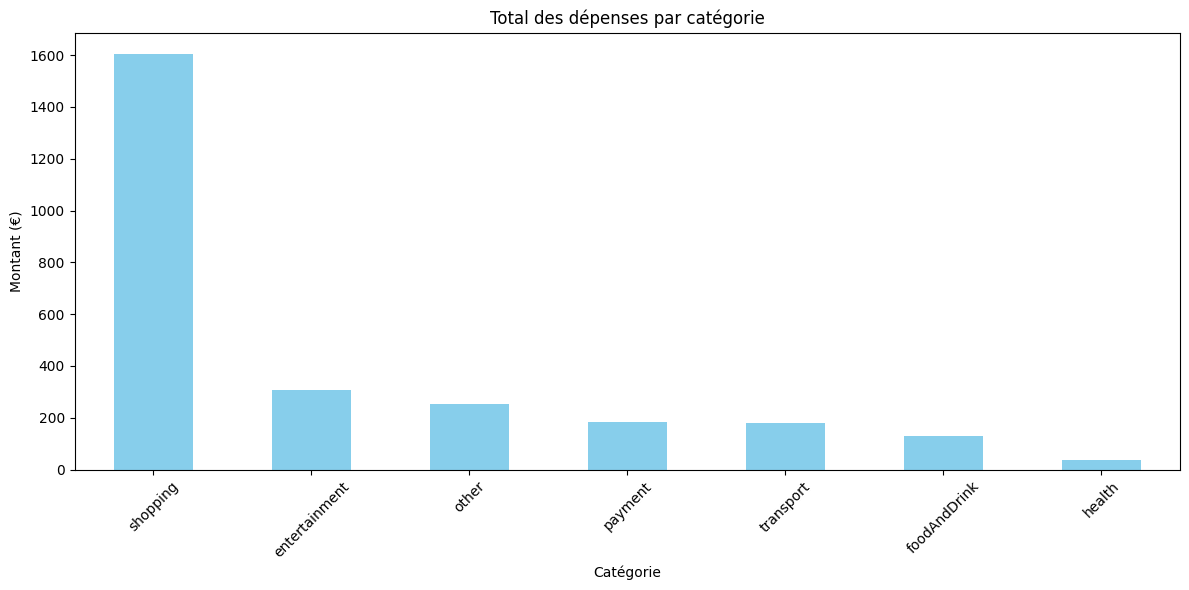

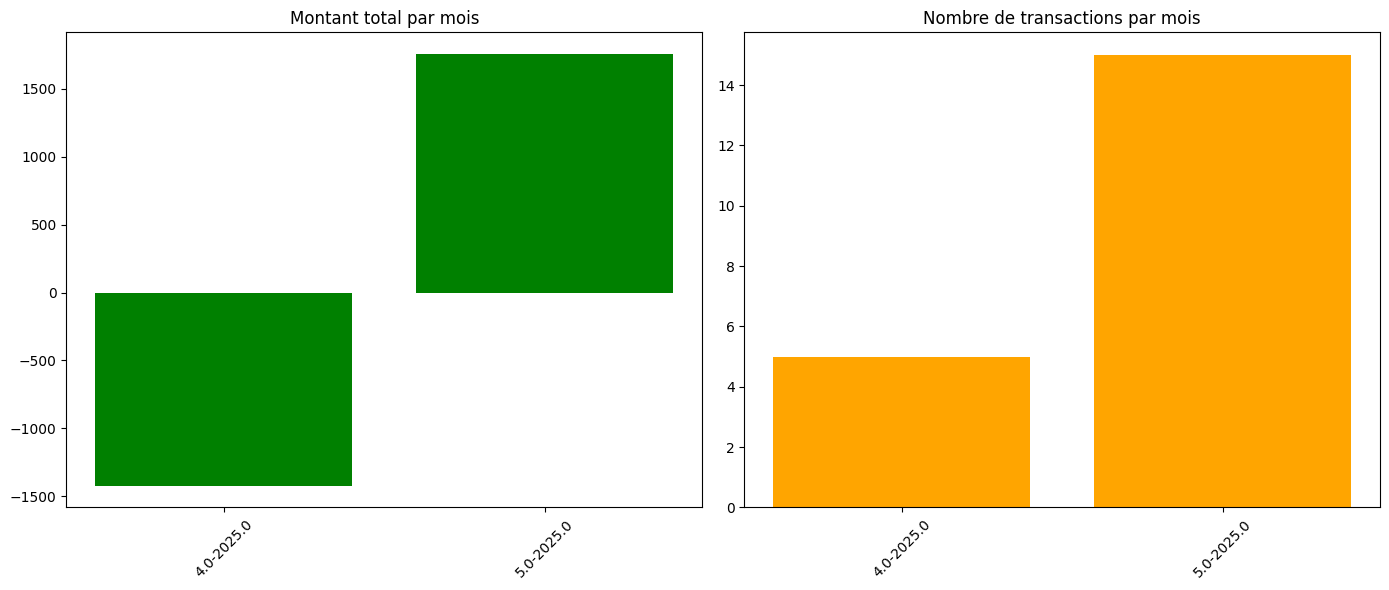

In [86]:
import pandas as pd
import json
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Charger les données
# Supposons que vos transactions sont dans un fichier 'mock_transactions.json'
with open('mock_transactions.json', 'r', encoding='utf-8') as f:
    transactions = json.load(f)

# Convertir les données en DataFrame pandas
df = pd.DataFrame(transactions)

# Convertir la colonne date en type datetime
df['date'] = pd.to_datetime(df['date'])

# Ajouter des colonnes utiles pour l'analyse
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day'] = df['date'].dt.day
df['month_name'] = df['date'].dt.month_name()
df['weekday'] = df['date'].dt.day_name()

# Extraire le nom de la catégorie et de la sous-catégorie pour faciliter le filtrage
df['category_id'] = df['category'].apply(lambda x: x['id'])
df['subcategory_id'] = df['category'].apply(lambda x: x['subcategory']['id'])

# Créer une colonne pour indiquer si c'est un revenu (montant négatif) ou une dépense (montant positif)
df['type'] = df['amount'].apply(lambda x: 'income' if x < 0 else 'expense')

# Afficher un aperçu des données
print("Aperçu des données de transactions :")
display(df.head())

# 2. Requête pour identifier les transactions récurrentes
# On va chercher des transactions qui apparaissent tous les mois avec des montants similaires
# et le même marchand

def get_recurring_transactions(df, threshold=0.15):
    """
    Identifie les transactions récurrentes basées sur:
    - Même commerçant
    - Montant similaire (variation < threshold)
    - Fréquence mensuelle
    """
    # Groupe par marchand et catégorie
    potential_recurring = df.groupby(['merchant_name', 'category_id', 'subcategory_id'])
    
    recurring_transactions = []
    
    for name, group in potential_recurring:
        merchant, cat_id, subcat_id = name
        
        # Vérifier si ce marchand apparaît au moins 2 fois
        if len(group) >= 2:
            # Vérifier si les montants sont similaires (variation <= threshold)
            amount_mean = group['amount'].mean()
            amount_std = group['amount'].std()
            
            # Coefficient de variation (écart-type/moyenne)
            if abs(amount_mean) > 0:  # Éviter division par zéro
                variation = amount_std / abs(amount_mean)
                
                # Si variation faible, c'est probablement récurrent
                if variation <= threshold:
                    # Vérifier si les dates sont espacées d'environ 1 mois
                    dates = group['date'].sort_values().to_list()
                    
                    # Si on a des transactions dans des mois différents
                    months = set(date.month for date in dates)
                    if len(months) >= 2 or len(group) >= 3:
                        recurring_transactions.append({
                            'merchant_name': merchant,
                            'category_id': cat_id, 
                            'subcategory_id': subcat_id,
                            'mean_amount': amount_mean,
                            'occurrences': len(group),
                            'dates': [d.strftime('%Y-%m-%d') for d in dates]
                        })
    
    return pd.DataFrame(recurring_transactions)

# Récupérer les transactions récurrentes
recurring_df = get_recurring_transactions(df)
print("\nTransactions récurrentes identifiées :")
display(recurring_df)

# 3. Requête pour identifier les transactions dynamiques (non récurrentes)
# Ce sont celles qui ne sont pas dans notre liste de transactions récurrentes

def get_dynamic_transactions(df, recurring_df):
    """
    Identifie les transactions qui ne sont pas récurrentes
    """
    # Créer un ensemble des combinaisons marchands/catégorie récurrentes
    recurring_combos = set()
    for _, row in recurring_df.iterrows():
        combo = (row['merchant_name'], row['category_id'], row['subcategory_id'])
        recurring_combos.add(combo)
    
    # Filtrer le DataFrame original pour garder seulement les non-récurrentes
    dynamic_mask = ~df.apply(lambda row: (row['merchant_name'], row['category_id'], row['subcategory_id']) in recurring_combos, axis=1)
    
    return df[dynamic_mask]

# Récupérer les transactions dynamiques
dynamic_df = get_dynamic_transactions(df, recurring_df)
print("\nExemples de transactions dynamiques (non récurrentes) :")
display(dynamic_df.head())

# 4. Requête pour obtenir les mois présents dans les données
months_in_data = df.groupby(['year', 'month', 'month_name']).size().reset_index(name='count')
months_in_data = months_in_data.sort_values(['year', 'month'])

print("\nMois présents dans les données :")
display(months_in_data)

# 5. Requête pour obtenir toutes les catégories principales disponibles
main_categories = df['category_id'].unique()
print("\nCatégories principales disponibles :")
print(main_categories)

# 6. Requête pour obtenir les sous-catégories pour chaque catégorie principale
subcategories_by_category = df.groupby('category_id')['subcategory_id'].unique()
print("\nSous-catégories par catégorie principale :")
display(subcategories_by_category)

# 7. Analyse des dépenses par catégorie (visualisation bonus)
plt.figure(figsize=(12, 6))
expenses = df[df['type'] == 'expense'].groupby('category_id')['amount'].sum().sort_values(ascending=False)
expenses.plot(kind='bar', color='skyblue')
plt.title('Total des dépenses par catégorie')
plt.ylabel('Montant (€)')
plt.xlabel('Catégorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8. Analyse des transactions dans le temps (visualisation bonus)
monthly_totals = df.groupby(['year', 'month'])['amount'].agg(['sum', 'count']).reset_index()
monthly_totals['month_year'] = monthly_totals.apply(lambda x: f"{x['month']}-{x['year']}", axis=1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(monthly_totals['month_year'], monthly_totals['sum'], color='green')
plt.title('Montant total par mois')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(monthly_totals['month_year'], monthly_totals['count'], color='orange')
plt.title('Nombre de transactions par mois')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Test format_transaction

### Load test data

In [53]:
test_data = load_schema("/Users/ninamessaoudi/Documents/Projects/Projets perso/CashSense/cash-sense-backend/notebooks/mock_transactions.json")

### Load plaid data

In [54]:
plaid_data = transactions

# Format transactions

In [55]:
def format_transaction(transaction):
    """
    Formate une transaction Plaid pour le frontend
    """
    # Vérifier si c'est déjà un dictionnaire avec le bon format de catégorie
    if isinstance(transaction, dict):
        # Si la catégorie est déjà au bon format, retourner tel quel
        if "category" in transaction and isinstance(transaction["category"], dict):
            return transaction
        
        # Si la catégorie est 'Non catégorisé', la convertir au bon format
        if "category" in transaction and transaction["category"] == "Non catégorisé":
            transaction["category"] = {
                "id": "other",
                "subcategory": {
                    "id": "unknown"
                }
            }
            return transaction
        
        # Si c'est un dict mais que la catégorie n'est pas au bon format,
        # on continue le traitement avec ce dictionnaire
        transaction_obj = transaction
    else:
        # Sinon, on suppose que c'est un objet Plaid
        transaction_obj = transaction
    
    # Préparer la structure de catégorie
    category_id = "other"
    subcategory_id = "unknown"
    
    # Traiter le champ category qui peut être une chaîne ou une liste
    if hasattr(transaction_obj, 'category') or (isinstance(transaction_obj, dict) and 'category' in transaction_obj):
        category_value = transaction_obj.category if hasattr(transaction_obj, 'category') else transaction_obj.get('category')
        
        # Si la catégorie est une chaîne
        if isinstance(category_value, str):
            # Cas spécial pour "Non catégorisé"
            if category_value == "Non catégorisé":
                # Utiliser les valeurs par défaut définies plus haut
                pass
            else:
                # Sinon, diviser la chaîne
                categories = category_value.split(', ')
                if categories:
                    category_id = categories[0].lower().replace(' ', '') if categories[0] else "other"
                    if len(categories) > 1:
                        subcategory_id = categories[1].lower().replace(' ', '')
        # Si c'est une liste, l'utiliser directement
        elif isinstance(category_value, list):
            categories = category_value
            if categories:
                category_id = categories[0].lower().replace(' ', '') if categories[0] else "other"
                if len(categories) > 1:
                    subcategory_id = categories[1].lower().replace(' ', '')
    
    # Construire le résultat final
    result = {
        "id": transaction_obj.id if hasattr(transaction_obj, 'id') else transaction_obj.get('id'),
        "date": transaction_obj.date if hasattr(transaction_obj, 'date') else transaction_obj.get('date'),
        "merchant_name": (transaction_obj.merchant_name if hasattr(transaction_obj, 'merchant_name') else transaction_obj.get('merchant_name')) or 
                        (transaction_obj.name if hasattr(transaction_obj, 'name') else transaction_obj.get('name')),
        "amount": transaction_obj.amount if hasattr(transaction_obj, 'amount') else transaction_obj.get('amount'),
        "category": {
            "id": category_id,
            "subcategory": {
                "id": subcategory_id
            }
        },
        "payment_channel": transaction_obj.payment_channel if hasattr(transaction_obj, 'payment_channel') else transaction_obj.get('payment_channel'),
        "pending": transaction_obj.pending if hasattr(transaction_obj, 'pending') else transaction_obj.get('pending', False),
        "is_test_data": False
    }
    
    return result

In [59]:
#second version

def format_transaction(transaction):
    """
    Formate une transaction pour assurer un format cohérent
    Conserve les données existantes si elles sont déjà au bon format
    """
    # Si c'est déjà un dictionnaire avec le format de catégorie correct
    if (isinstance(transaction, dict) and 
        "category" in transaction and 
        isinstance(transaction["category"], dict) and
        "subcategory" in transaction["category"] and
        isinstance(transaction["category"]["subcategory"], dict)):
        return transaction
    
    # Déterminer si c'est un dict ou un objet
    is_dict = isinstance(transaction, dict)
    
    # Extraire les valeurs (soit d'un dict, soit d'un objet)
    def get_value(key, default=None):
        if is_dict:
            return transaction.get(key, default)
        return getattr(transaction, key, default)
    
    # Traiter la catégorie
    category_id = "other"
    subcategory_id = "unknown"
    
    category_value = get_value('category')
    if category_value:
        if isinstance(category_value, dict):
            # Si la catégorie est déjà un dict mais pas complètement formatée
            category_id = category_value.get('id', 'other')
            if 'subcategory' in category_value and isinstance(category_value['subcategory'], dict):
                subcategory_id = category_value['subcategory'].get('id', 'unknown')
        elif isinstance(category_value, str):
            if category_value != "Non catégorisé":
                categories = category_value.split(', ')
                if categories:
                    category_id = categories[0].lower().replace(' ', '') if categories[0] else "other"
                    if len(categories) > 1:
                        subcategory_id = categories[1].lower().replace(' ', '')
        elif isinstance(category_value, list):
            if category_value:
                category_id = category_value[0].lower().replace(' ', '') if category_value[0] else "other"
                if len(category_value) > 1:
                    subcategory_id = category_value[1].lower().replace(' ', '')
    
    # Construire le résultat
    result = {
        "id": get_value('id', f"txn_{uuid.uuid4().hex[:12]}"),
        "date": get_value('date', datetime.now().strftime('%Y-%m-%d')),
        "merchant_name": get_value('merchant_name') or get_value('name', "Unknown Merchant"),
        "amount": get_value('amount', 0.0),
        "category": {
            "id": category_id,
            "subcategory": {
                "id": subcategory_id
            }
        },
        "payment_channel": get_value('payment_channel', 'other'),
        "pending": get_value('pending', False),
        "is_test_data": get_value('is_test_data', False)
    }
    
    return result

## apply on test data

In [60]:
formated_transaction_list = []  # Utilise une liste vide plutôt que dict
for transaction in test_data:
    formatted_transaction = format_transaction(transaction)
    formated_transaction_list.append(formatted_transaction)
formated_transaction_list

[{'amount': 713.77,
  'payment_channel': 'in store',
  'merchant_name': 'Apple Store',
  'date': '2025-05-01',
  'pending': False,
  'id': 'txn_94e71f5a3774',
  'category': {'id': 'shopping', 'subcategory': {'id': 'electronics'}}},
 {'amount': 44.53,
  'payment_channel': 'in store',
  'pending': False,
  'merchant_name': 'PlayStation Store',
  'date': '2025-05-01',
  'id': 'txn_909b994711b4',
  'category': {'id': 'entertainment', 'subcategory': {'id': 'games'}}},
 {'amount': 69.12,
  'payment_channel': 'online',
  'pending': False,
  'merchant_name': 'Disney+',
  'date': '2025-05-01',
  'id': 'txn_a626521de556',
  'category': {'id': 'entertainment', 'subcategory': {'id': 'sports'}}},
 {'amount': 24.96,
  'payment_channel': 'online',
  'pending': False,
  'merchant_name': 'Cultura',
  'date': '2025-05-01',
  'id': 'txn_ebf3f14a7d13',
  'category': {'id': 'shopping', 'subcategory': {'id': 'electronics'}}},
 {'amount': 78.41,
  'payment_channel': 'atm',
  'pending': False,
  'merchant_nam

## apply on plaid data

In [61]:
formated_transaction_list = []  # Utilise une liste vide plutôt que dict
for transaction in transactions:
    formatted_transaction = format_transaction(transaction)
    formated_transaction_list.append(formatted_transaction)
formated_transaction_list

[{'id': 'kqpPjjMjDAIx3Vzwka5Kc3JeBAx39btL1ALjP',
  'date': datetime.date(2025, 5, 2),
  'name': 'Uber 072515 SF**POOL**',
  'amount': 6.33,
  'category': {'id': 'other', 'subcategory': {'id': 'unknown'}},
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None,
  'is_test_data': False},
 {'id': 'a5PKyy6yX7FWwx9ZEGBLck8zVJEkdbtZKVZaK',
  'date': datetime.date(2025, 4, 29),
  'name': 'Tectra Inc',
  'amount': 500.0,
  'category': {'id': 'other', 'subcategory': {'id': 'unknown'}},
  'payment_channel': 'other',
  'pending': False,
  'merchant_name': None,
  'is_test_data': False},
 {'id': 'P5j6XXkXW7Fax6qZdRBgCXjZa5wXvVuoyVok6',
  'date': datetime.date(2025, 4, 28),
  'merchant_name': 'AUTOMATIC PAYMENT - THANK',
  'amount': 2078.5,
  'category': {'id': 'payment', 'subcategory': {'id': 'creditcard'}},
  'payment_channel': 'other',
  'pending': False,
  'is_test_data': False},
 {'id': 'N5M6bb8bNPFxk9AMLdvpcXD3a5xXk6uyAkyjp',
  'date': datetime.date(2025, 4, 28),
  'merchan

# Generateur de transactions aleatoires

In [164]:
"""
Module qui génère des données de transactions fictives pour le mode test.
"""
import random
import uuid
from datetime import datetime, timedelta
import calendar


# Données de base pour générer des transactions
MERCHANTS = {
    'foodAndDrink': ['Restaurant Le Gourmet', 'Carrefour'],
    'shopping': ['Amazon', 'Zara'],
    'transport': ['RATP', 'Uber'],
    'travel': ['Booking.com', 'Air France'],
    'transfer': ['BNP Paribas', 'Société Générale'],
    'payment': ['EDF', 'Orange'],
    'health': ['Pharmacie Centrale', 'Dr Martin'],
    'entertainment': ['Netflix', 'Spotify'],
    'income': ['Entreprise XYZ', 'Freelance'],
    'other': ['Frais Bancaires', 'Divers']
}

# Configuration des transactions
TX_TYPES = {
    # Transactions récurrentes
    "RECURRING": [
        {"name": "Salaire", "category": "income", "subcategory": "salary", "amount": (-2000, -1800), "days": [1, 30]},
        {"name": "Loyer", "category": "payment", "subcategory": "bills", "amount": (600, 1200), "days": [1, 5]},
        {"name": "Internet", "category": "payment", "subcategory": "bills", "amount": (30, 60), "days": [5, 15]},
        {"name": "Électricité", "category": "payment", "subcategory": "bills", "amount": (40, 120), "days": [7, 17]},
        {"name": "Netflix", "category": "entertainment", "subcategory": "subscriptions", "amount": (9, 18), "days": [10, 20]}
    ],
    
    # Transactions exceptionnelles
    "SPECIAL": [
        {"name": "Restaurant Gastronomique", "category": "foodAndDrink", "subcategory": "restaurants", 
         "amount": (80, 200), "months": None, "probability": 0.2},
        {"name": "Apple Store", "category": "shopping", "subcategory": "electronics", 
         "amount": (100, 1200), "months": None, "probability": 0.15},
        {"name": "Prime", "category": "income", "subcategory": "salary", 
         "amount": (-1000, -300), "months": None, "probability": 0.1},
        {"name": "Transport Vacances", "category": "travel", "subcategory": "trainTickets", 
         "amount": (80, 300), "months": [6, 7, 8], "probability": 0.6},
        {"name": "Cadeaux Noël", "category": "shopping", "subcategory": "clothing", 
         "amount": (50, 300), "months": [12], "probability": 0.8}
    ]
}

def create_transaction(data, date):
    """Crée une transaction formatée à partir des données de base"""
    # Générer un montant aléatoire dans la plage spécifiée
    min_amount, max_amount = data.get("amount", (5, 200))
    amount = round(random.uniform(min_amount, max_amount), 2)
    
    # Créer la structure de la transaction
    tx = {
        "amount": amount,
        "date": date.strftime("%Y-%m-%d"),
        "merchant_name": data.get("name", "Inconnu"),
        "payment_channel": "online" if amount < 0 else random.choice(["in store", "online"]),
        "pending": False,
        "id": f"txn_{uuid.uuid4().hex[:12]}",
        "category": {
            "id": data.get("category", "other"),
            "subcategory": {
                "id": data.get("subcategory", "unknown")
            }
        },
        "is_test_data": True
    }
    
    # Valider le format avec notre validateur standard
    return format_transaction(tx)

def generate_monthly_transactions(year, month, start_date=None, end_date=None, min_count=10):
    """Génère les transactions pour un mois spécifique, en garantissant les récurrentes"""
    # Calculer les dates du mois
    month_start = datetime(year, month, 1).date()
    last_day = calendar.monthrange(year, month)[1]
    month_end = datetime(year, month, last_day).date()
    
    # Appliquer les filtres de date si nécessaire
    if (start_date and start_date > month_end) or (end_date and end_date < month_start):
        return []
        
    actual_start = max(month_start, start_date) if start_date else month_start
    actual_end = min(month_end, end_date) if end_date else month_end
    
    if actual_start > actual_end:
        return []
    
    transactions = []
    
    # 1. Ajouter les transactions récurrentes - TOUJOURS dans les 5 premiers jours du mois
    for index, tx_config in enumerate(TX_TYPES["RECURRING"]):
        # Attribuer un jour fixe entre 1 et 5 (en fonction de l'index de la transaction)
        fixed_day = (index % 5) + 1  # Jour entre 1 et 5
        
        # Vérifier que le jour est valide pour ce mois (pour gérer les mois courts)
        if fixed_day <= last_day:
            # Créer la date pour cette transaction
            tx_date = datetime(year, month, fixed_day).date()
            
            # Créer la transaction (sans tenir compte de la période filtrée)
            # Cela garantit que chaque mois aura toujours ses transactions récurrentes
            tx_config_copy = tx_config.copy()
            tx_config_copy["days"] = [fixed_day]  # Jour fixe pour documentation
            transactions.append(create_transaction(tx_config_copy, tx_date))
    
    # 2. Ajouter les transactions spéciales pour ce mois
    for tx_config in TX_TYPES["SPECIAL"]:
        # Vérifier si la transaction s'applique ce mois-ci
        if tx_config["months"] and month not in tx_config["months"]:
            continue
            
        # Vérifier la probabilité
        if random.random() > tx_config["probability"]:
            continue
            
        # Choisir une date aléatoire dans la période filtrée du mois
        days_in_range = (actual_end - actual_start).days + 1
        random_day = random.randint(0, days_in_range - 1)
        tx_date = actual_start + timedelta(days=random_day)
        
        # Ajouter la transaction
        transactions.append(create_transaction(tx_config, tx_date))
    
    # 3. Compléter avec des transactions aléatoires pour atteindre le minimum
    while len(transactions) < min_count:
        # Choisir une date aléatoire dans la période filtrée
        days_in_range = (actual_end - actual_start).days + 1
        random_day = random.randint(0, days_in_range - 1)
        tx_date = actual_start + timedelta(days=random_day)
        
        # Choisir une catégorie aléatoire
        cat_id = random.choice(list(CATEGORIES_SCHEMA.keys()))
        subcat_id = random.choice(list(CATEGORIES_SCHEMA[cat_id]["subcategories"].keys()))
        
        # Déterminer si c'est un revenu
        is_income = cat_id == "income"
        
        # Générer la transaction
        tx_data = {
            "category": cat_id,
            "subcategory": subcat_id,
            "name": random.choice(MERCHANTS.get(cat_id, ["Inconnu"])),
            "amount": (-200, -50) if is_income else (5, 200)
        }
        
        # Ajouter la transaction
        transactions.append(create_transaction(tx_data, tx_date))
    
    # Tri par date (du plus récent au plus ancien)
    return sorted(transactions, key=lambda x: x["date"], reverse=True)

def get_mock_transactions(days=30, count=None):
    """Génère des transactions de test sur une période donnée"""
    # Calculer la période
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=days)
    
    # Générer les transactions pour chaque mois
    all_transactions = []
    current = start_date.replace(day=1)
    
    while current <= end_date:
        year, month = current.year, current.month
        monthly_txs = generate_monthly_transactions(year, month, start_date, end_date, 15)
        all_transactions.extend(monthly_txs)
        
        # Passer au mois suivant
        if month == 12:
            current = current.replace(year=year+1, month=1)
        else:
            current = current.replace(month=month+1)
    
    # Ajuster le nombre si nécessaire
    if count is not None:
        if len(all_transactions) < count:
            # Ajouter des transactions supplémentaires pour atteindre le nombre demandé
            for _ in range(count - len(all_transactions)):
                # Choisir une date aléatoire dans la période
                random_date = start_date + timedelta(days=random.randint(0, days))
                
                # Choisir une catégorie aléatoire
                cat_id = random.choice(list(CATEGORIES_SCHEMA.keys()))
                subcat_id = random.choice(list(CATEGORIES_SCHEMA[cat_id]["subcategories"].keys()))
                
                # Générer la transaction
                tx_data = {
                    "category": cat_id,
                    "subcategory": subcat_id,
                    "name": random.choice(MERCHANTS.get(cat_id, ["Inconnu"])),
                    "amount": (-200, -50) if cat_id == "income" else (5, 200)
                }
                
                # Ajouter la transaction
                all_transactions.append(create_transaction(tx_data, random_date))
        elif len(all_transactions) > count:
            # Limiter au nombre demandé
            all_transactions = all_transactions[:count]
    
    # Tri final (du plus récent au plus ancien)
    return sorted(all_transactions, key=lambda x: x["date"], reverse=True)

In [165]:
transactions = get_mock_transactions(days=60, count=204)

In [166]:
len(transactions)

204

## Verification de la qualitées des transactions de test generées :

1. Vérifier que les transactions couvrent bien la période demandée

In [162]:
import pandas as pd
from datetime import datetime, timedelta

# Convertir en DataFrame pour faciliter l'analyse
df = pd.DataFrame(transactions)
df['date'] = pd.to_datetime(df['date'])

# Vérifier la plage de dates
today = datetime.now().date()
expected_start = today - timedelta(days=60)

print(f"Période attendue: de {expected_start} à {today}")
print(f"Période réelle: de {df['date'].min().date()} à {df['date'].max().date()}")
print(f"Nombre total de jours: {(df['date'].max().date() - df['date'].min().date()).days + 1}")

# Vérifier la couverture mensuelle
months_covered = df['date'].dt.to_period('M').unique()
print(f"\nMois couverts: {', '.join([str(m) for m in months_covered])}")
print(f"Nombre de mois uniques: {len(months_covered)}")

# Compter les transactions par mois
monthly_counts = df.groupby(df['date'].dt.to_period('M')).size()
print("\nNombre de transactions par mois:")
for month, count in monthly_counts.items():
    print(f"- {month}: {count} transactions")

Période attendue: de 2025-03-06 à 2025-05-05
Période réelle: de 2025-03-01 à 2025-05-05
Nombre total de jours: 66

Mois couverts: 2025-05, 2025-04, 2025-03
Nombre de mois uniques: 3

Nombre de transactions par mois:
- 2025-03: 82 transactions
- 2025-04: 97 transactions
- 2025-05: 25 transactions


In [163]:
# Identifier les transactions récurrentes
recurring_types = ["Salaire", "Loyer", "Internet", "Électricité", "Netflix"]

print("Vérification des transactions récurrentes:")
for tx_type in recurring_types:
    matches = df[df['merchant_name'].str.contains(tx_type, case=False, na=False)]
    print(f"\n{tx_type}:")
    if not matches.empty:
        print(f"- {len(matches)} occurrences trouvées")
        # Grouper par mois pour vérifier la récurrence mensuelle
        monthly = matches.groupby(matches['date'].dt.to_period('M')).size()
        print(f"- Présent dans {len(monthly)} mois sur {len(months_covered)} mois couverts")
        # Afficher quelques exemples
        print("- Exemples:")
        for _, row in matches.head(3).iterrows():
            print(f"  - {row['date'].date()}: {row['merchant_name']} - {row['amount']}€")
    else:
        print("- Aucune occurrence trouvée")

Vérification des transactions récurrentes:

Salaire:
- 3 occurrences trouvées
- Présent dans 3 mois sur 3 mois couverts
- Exemples:
  - 2025-05-01: Salaire - -1933.58€
  - 2025-04-01: Salaire - -1869.83€
  - 2025-03-01: Salaire - -1987.85€

Loyer:
- 3 occurrences trouvées
- Présent dans 3 mois sur 3 mois couverts
- Exemples:
  - 2025-05-02: Loyer - 1020.83€
  - 2025-04-02: Loyer - 1035.25€
  - 2025-03-02: Loyer - 894.1€

Internet:
- 3 occurrences trouvées
- Présent dans 3 mois sur 3 mois couverts
- Exemples:
  - 2025-05-03: Internet - 39.03€
  - 2025-04-03: Internet - 35.73€
  - 2025-03-03: Internet - 42.51€

Électricité:
- 3 occurrences trouvées
- Présent dans 3 mois sur 3 mois couverts
- Exemples:
  - 2025-05-04: Électricité - 60.4€
  - 2025-04-04: Électricité - 76.29€
  - 2025-03-04: Électricité - 43.18€

Netflix:
- 15 occurrences trouvées
- Présent dans 3 mois sur 3 mois couverts
- Exemples:
  - 2025-05-05: Netflix - 10.22€
  - 2025-05-03: Netflix - 166.69€
  - 2025-05-01: Netflix 

In [154]:
# Identifier les transactions spéciales
special_types = ["Restaurant Gastronomique", "Apple Store", "Prime", "Transport Vacances", "Cadeaux Noël"]

print("Vérification des transactions spéciales:")
for tx_type in special_types:
    matches = df[df['merchant_name'].str.contains(tx_type, case=False, na=False)]
    print(f"\n{tx_type}:")
    if not matches.empty:
        print(f"- {len(matches)} occurrences trouvées")
        # Vérifier la variabilité des montants
        print(f"- Montant min: {matches['amount'].min()}€, max: {matches['amount'].max()}€")
        # Afficher quelques exemples
        print("- Exemples:")
        for _, row in matches.iterrows():
            print(f"  - {row['date'].date()}: {row['merchant_name']} - {row['amount']}€")
    else:
        print("- Aucune occurrence trouvée")

Vérification des transactions spéciales:

Restaurant Gastronomique:
- Aucune occurrence trouvée

Apple Store:
- 1 occurrences trouvées
- Montant min: 503.49€, max: 503.49€
- Exemples:
  - 2025-03-30: Apple Store - 503.49€

Prime:
- 1 occurrences trouvées
- Montant min: -932.67€, max: -932.67€
- Exemples:
  - 2025-04-04: Prime - -932.67€

Transport Vacances:
- Aucune occurrence trouvée

Cadeaux Noël:
- Aucune occurrence trouvée


# Voir les transaction qui sont ni recurentes ni speciales

In [155]:
def filter_random_transactions(transactions):
    """
    Filtre les transactions pour ne conserver que celles qui sont ni récurrentes ni spéciales.
    """
    # Liste des noms de transactions récurrentes
    recurring_names = [tx["name"] for tx in TX_TYPES["RECURRING"]]
    
    # Liste des noms de transactions spéciales
    special_names = [tx["name"] for tx in TX_TYPES["SPECIAL"]]
    
    # Filtrer les transactions
    random_transactions = [
        tx for tx in transactions 
        if tx["merchant_name"] not in recurring_names and tx["merchant_name"] not in special_names
    ]
    
    return random_transactions

# Utilisation
random_only = filter_random_transactions(transactions)

# Afficher le nombre de transactions de chaque type
print(f"Total des transactions: {len(transactions)}")
print(f"Transactions aléatoires: {len(random_only)}")
print(f"Pourcentage de transactions aléatoires: {len(random_only)/len(transactions)*100:.1f}%")

# Afficher quelques exemples de transactions aléatoires
for tx in random_only[:5]:
    print(f"{tx['date']} - {tx['merchant_name']} - {tx['amount']:.2f}€")

Total des transactions: 204
Transactions aléatoires: 176
Pourcentage de transactions aléatoires: 86.3%
2025-05-05 - Spotify - 119.22€
2025-05-05 - Amazon - 150.82€
2025-05-05 - RATP - 148.39€
2025-05-05 - Pharmacie Centrale - 64.06€
2025-05-05 - Spotify - 80.17€
